# 05 — Strategy Backtest and PnL

**Goal:** Translate model predictions into a simulated trading strategy and measure performance.

**Strategy logic:**
- Long when P(outperform) > 0.60
- Short when P(outperform) < 0.40
- Flat otherwise
- Hold for 5 trading days post-earnings
- Deduct 20bps round-trip transaction cost

**Metrics:** Cumulative PnL, Sharpe Ratio, Win Rate, Max Drawdown

In [1]:
# ── Imports ────────────────────────────────────────────────────
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')

# ── Load predictions ───────────────────────────────────────────
try:
    lgbm  = pd.read_csv('../data/lgbm_predictions.csv',  parse_dates=['earn_date'])
    logit = pd.read_csv('../data/logit_predictions.csv', parse_dates=['earn_date'])
    lgbm  = lgbm.sort_values('earn_date').reset_index(drop=True)
    logit = logit.sort_values('earn_date').reset_index(drop=True)
    print(f'LightGBM predictions : {len(lgbm):,} events')
    print(f'Logit predictions    : {len(logit):,} events')
except FileNotFoundError as e:
    print(f'Missing file: {e}')
    print('Run notebooks 03 and 04 first.')

LightGBM predictions : 1,611 events
Logit predictions    : 1,611 events


In [2]:
# ── Backtest Function ──────────────────────────────────────────
def run_backtest(df, proba_col='lgbm_proba', ret_col='excess_ret_5d',
                 long_threshold=0.60, short_threshold=0.40,
                 cost_bps=20, label='Model'):
    df   = df.copy().dropna(subset=[proba_col, ret_col])
    cost = cost_bps / 10_000

    df['signal'] = 0
    df.loc[df[proba_col] > long_threshold,  'signal'] =  1
    df.loc[df[proba_col] < short_threshold, 'signal'] = -1

    df['pnl'] = df['signal'] * df[ret_col] - np.abs(df['signal']) * cost

    active = df[df['signal'] != 0].copy()
    active = active.sort_values('earn_date').reset_index(drop=True)
    active['cum_pnl'] = active['pnl'].cumsum()

    if len(active) == 0:
        print('No trades at this threshold.')
        return None, None

    n_trades  = len(active)
    win_rate  = (active['pnl'] > 0).mean()
    avg_ret   = active['pnl'].mean()
    total_ret = active['pnl'].sum()
    vol       = active['pnl'].std()
    sharpe    = (avg_ret / (vol + 1e-9)) * np.sqrt(n_trades)

    rolling_max = active['cum_pnl'].cummax()
    max_dd      = (active['cum_pnl'] - rolling_max).min()

    metrics = {
        'label':     label,
        'n_trades':  n_trades,
        'win_rate':  win_rate,
        'avg_ret':   avg_ret,
        'total_ret': total_ret,
        'sharpe':    sharpe,
        'max_dd':    max_dd,
        'n_long':    (active['signal'] ==  1).sum(),
        'n_short':   (active['signal'] == -1).sum(),
    }
    return active, metrics


def print_metrics(m):
    if m is None:
        return
    print(f"\n{'─'*45}")
    print(f"  Strategy : {m['label']}")
    print(f"{'─'*45}")
    print(f"  Trades   : {m['n_trades']:,}  ({m['n_long']} long / {m['n_short']} short)")
    print(f"  Win rate : {m['win_rate']:.1%}")
    print(f"  Avg/trade: {m['avg_ret']*100:+.3f}%")
    print(f"  Total    : {m['total_ret']*100:+.2f}%")
    print(f"  Sharpe   : {m['sharpe']:+.2f}")
    print(f"  Max DD   : {m['max_dd']*100:.2f}%")

In [3]:
# ── Run Backtests ──────────────────────────────────────────────
active_lgbm,  metrics_lgbm  = run_backtest(lgbm,  label='LightGBM')
active_logit, metrics_logit = run_backtest(
    logit, proba_col='proba', label='Logistic Regression'
)

print_metrics(metrics_lgbm)
print_metrics(metrics_logit)

naive_ret = lgbm['excess_ret_5d'].mean() * 100
print(f'\nNaive baseline (long every event): {naive_ret:+.3f}% avg excess return')


─────────────────────────────────────────────
  Strategy : LightGBM
─────────────────────────────────────────────
  Trades   : 301  (12 long / 289 short)
  Win rate : 46.8%
  Avg/trade: -0.255%
  Total    : -76.62%
  Sharpe   : -0.94
  Max DD   : -180.00%

─────────────────────────────────────────────
  Strategy : Logistic Regression
─────────────────────────────────────────────
  Trades   : 940  (448 long / 492 short)
  Win rate : 49.1%
  Avg/trade: -0.090%
  Total    : -84.40%
  Sharpe   : -0.48
  Max DD   : -244.34%

Naive baseline (long every event): +0.168% avg excess return


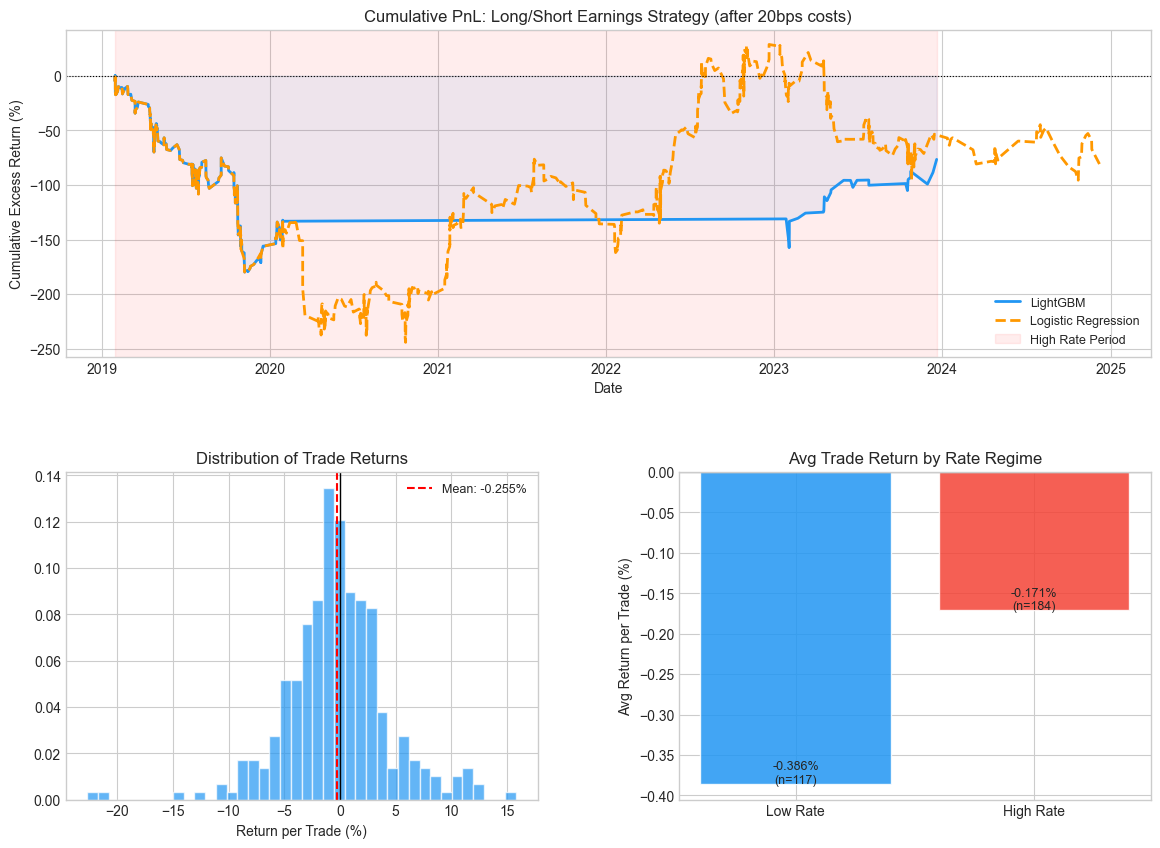

In [4]:
# ── Cumulative PnL Chart ───────────────────────────────────────
fig = plt.figure(figsize=(14, 10))
gs  = gridspec.GridSpec(2, 2, hspace=0.35, wspace=0.3)

# Panel A: Cumulative PnL over time
ax1 = fig.add_subplot(gs[0, :])
if active_lgbm is not None:
    ax1.plot(active_lgbm['earn_date'], active_lgbm['cum_pnl'] * 100,
             color='#2196F3', linewidth=2, label='LightGBM')
    ax1.fill_between(active_lgbm['earn_date'], 0,
                     active_lgbm['cum_pnl'] * 100,
                     alpha=0.08, color='#2196F3')
if active_logit is not None:
    ax1.plot(active_logit['earn_date'], active_logit['cum_pnl'] * 100,
             color='#FF9800', linewidth=2, linestyle='--',
             label='Logistic Regression')

ax1.axhline(0, color='black', linewidth=0.8, linestyle=':')

# Shade high-rate period
if active_lgbm is not None and 'rate_regime' in active_lgbm.columns:
    high = active_lgbm[active_lgbm['rate_regime'] == 1]
    if not high.empty:
        ax1.axvspan(high['earn_date'].min(), high['earn_date'].max(),
                    alpha=0.07, color='red', label='High Rate Period')

ax1.set_title('Cumulative PnL: Long/Short Earnings Strategy (after 20bps costs)')
ax1.set_ylabel('Cumulative Excess Return (%)')
ax1.set_xlabel('Date')
ax1.legend(fontsize=9)

# Panel B: Trade return distribution
ax2 = fig.add_subplot(gs[1, 0])
if active_lgbm is not None:
    ax2.hist(active_lgbm['pnl'] * 100, bins=40,
             color='#2196F3', alpha=0.7, edgecolor='white', density=True)
    ax2.axvline(0, color='black', linewidth=1)
    ax2.axvline(active_lgbm['pnl'].mean() * 100, color='red',
                linestyle='--',
                label=f'Mean: {active_lgbm["pnl"].mean()*100:+.3f}%')
    ax2.set_title('Distribution of Trade Returns')
    ax2.set_xlabel('Return per Trade (%)')
    ax2.legend(fontsize=9)

# Panel C: Performance by regime
ax3 = fig.add_subplot(gs[1, 1])
if active_lgbm is not None and 'rate_regime' in active_lgbm.columns:
    regime_perf = active_lgbm.groupby('rate_regime')['pnl'].agg(['mean', 'count'])
    regime_perf.index = ['Low Rate', 'High Rate']
    ax3.bar(regime_perf.index, regime_perf['mean'] * 100,
            color=['#2196F3', '#F44336'], edgecolor='white', alpha=0.85)
    ax3.axhline(0, color='black', linewidth=0.8)
    for i, (idx, row) in enumerate(regime_perf.iterrows()):
        ax3.text(i, row['mean'] * 100 + 0.001,
                 f'{row["mean"]*100:+.3f}%\n(n={int(row["count"])})',
                 ha='center', fontsize=9)
    ax3.set_title('Avg Trade Return by Rate Regime')
    ax3.set_ylabel('Avg Return per Trade (%)')

plt.savefig('../outputs/05_backtest_pnl.png', dpi=150, bbox_inches='tight')
plt.show()

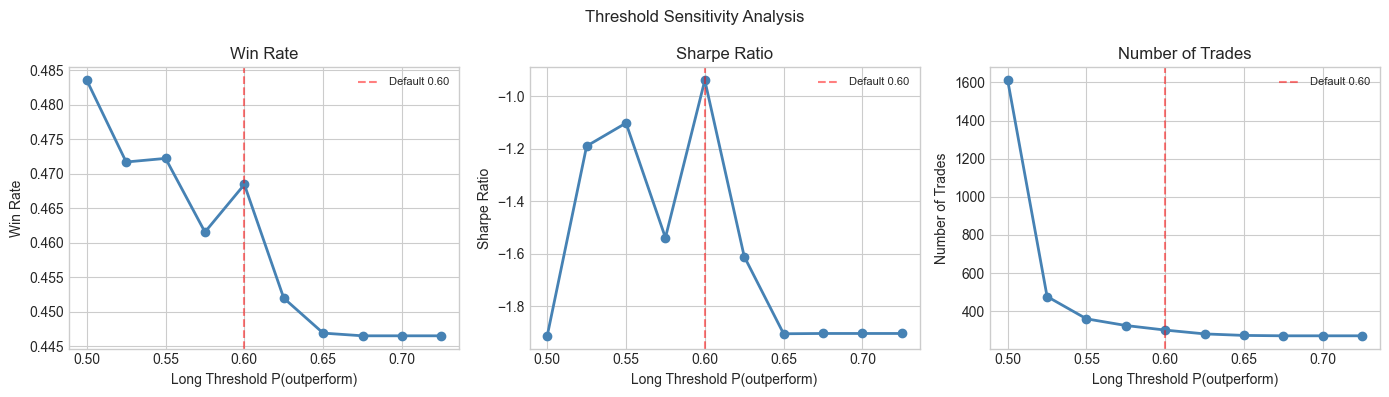

Higher threshold = fewer trades, higher win rate, lower total return


In [5]:
# ── Threshold Sensitivity ──────────────────────────────────────
thresholds        = np.arange(0.50, 0.75, 0.025)
threshold_results = []

for t in thresholds:
    _, m = run_backtest(lgbm, long_threshold=t,
                        short_threshold=1-t, label=f'{t:.2f}')
    if m:
        threshold_results.append(m)

thresh_df = pd.DataFrame(threshold_results)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
fig.suptitle('Threshold Sensitivity Analysis', fontsize=12)

for ax, col, label in [
    (axes[0], 'win_rate', 'Win Rate'),
    (axes[1], 'sharpe',   'Sharpe Ratio'),
    (axes[2], 'n_trades', 'Number of Trades')
]:
    ax.plot(thresholds, thresh_df[col], 'o-', color='steelblue', linewidth=2)
    ax.set_xlabel('Long Threshold P(outperform)')
    ax.set_ylabel(label)
    ax.set_title(label)
    ax.axvline(0.60, color='red', linestyle='--', alpha=0.5, label='Default 0.60')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig('../outputs/05_threshold_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()
print('Higher threshold = fewer trades, higher win rate, lower total return')

In [6]:
# ── Final Summary Table ────────────────────────────────────────
print('\n' + '='*50)
print(' FINAL RESULTS SUMMARY')
print('='*50)

summary_data = [m for m in [metrics_logit, metrics_lgbm] if m is not None]
summary_df   = pd.DataFrame(summary_data).set_index('label')

summary_df['win_rate']  = summary_df['win_rate'].apply(lambda x: f'{x:.1%}')
summary_df['avg_ret']   = summary_df['avg_ret'].apply(lambda x: f'{x*100:+.3f}%')
summary_df['total_ret'] = summary_df['total_ret'].apply(lambda x: f'{x*100:+.2f}%')
summary_df['max_dd']    = summary_df['max_dd'].apply(lambda x: f'{x*100:.2f}%')
summary_df['sharpe']    = summary_df['sharpe'].apply(lambda x: f'{x:.2f}')

print(summary_df[['n_trades', 'win_rate', 'avg_ret', 'sharpe', 'max_dd']].to_string())
print()
print('Notes:')
print('  Returns are excess vs S&P 500 (alpha), not absolute')
print('  Costs: 20bps round-trip per trade')
print('  This is a backtest -- past performance does not equal future results')


 FINAL RESULTS SUMMARY
                     n_trades win_rate  avg_ret sharpe    max_dd
label                                                           
Logistic Regression       940    49.1%  -0.090%  -0.48  -244.34%
LightGBM                  301    46.8%  -0.255%  -0.94  -180.00%

Notes:
  Returns are excess vs S&P 500 (alpha), not absolute
  Costs: 20bps round-trip per trade
  This is a backtest -- past performance does not equal future results
